# Imports

In [2]:
#%matplotlib notebook
%matplotlib inline 

import matplotlib
import seaborn as sb
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import holoviews as hv

import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import pickle as pk
from time import time
import io

import datetime
import sys

from IPython.display import display, HTML
from ipywidgets import widgets
from ipywidgets.widgets import interact, interactive, interactive_output, fixed, Widget 
from ipywidgets.widgets import IntSlider, FloatSlider, Layout, ToggleButton, ToggleButtons, Checkbox, RadioButtons, Dropdown, Button
from ipywidgets.widgets import HBox, VBox, Label,Text

#  !pip3 install mpld3
# import mpld3
#pld3.enable_notebook() causes plotting to not work???

from scipy.integrate import odeint
# !pip3 install lmfit
import lmfit
from lmfit.lineshapes import gaussian, lorentzian, exponential

from time import time
import warnings
warnings.filterwarnings('ignore')
# JSM added
# from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
from Cluster import * 

In [4]:
bd = BaseData('data_all_base')

reading in data from data_all_base ...
elapsed:  10.837564945220947


In [5]:
# run 
# clusdtypes should be in ['JRP1','ORP1','JWP1','OWP1','JRT1','ORT1','JWT1','OWT1']
# database JHU/OWID  (J/O) 
# report_correct T or F   (R/W)
# syncat peak/thresh  (P/T)
clusdtype='JRT1'
ClData = get_cluster_data(clusdtype)

reading in data from ./pks/data_cluster_JRT1.pk ...


In [6]:
exec(open('ClusterFit.py','r').read())

In [7]:
# changed to use model_fits_age : this is backwards compatible and only loads data if needed
import data_config
data_config.data_loaded = True    
from model_fits_age import *  # including ModelFit class definition. 

data already loaded, so no "from data import *" required.
making the models...
SC2UIR
SC2FIR
SC3FEIR
SEI3R
SC3FEI3R
SC2FUIR
SC3FUEI3R
done with the models.


In [8]:
# eliminate countries with no population data (needed for normalizing death stats for fits)

#for country in countries:
#    if population_owid[country][0] == 0:
#        print(country)
        
countries = [cc for cc in bd.countries_common if bd.population_owid[cc][-2] > 0]
print(len(countries),'countries with population data')
countries_zp = [cc for cc in bd.countries_common if bd.population_owid[cc][-2] == 0]
print('common countries without population data',countries_zp)
cluster_countries = [c for c in ClData.clusdata_all['deaths']]
print(len(cluster_countries),'cluster countries')


198 countries with population data
common countries without population data []
74 cluster countries


In [9]:
[x for x in fullmodels]

['SC2UIR', 'SC2FIR', 'SC3FEIR', 'SEI3R', 'SC3FEI3R', 'SC2FUIR', 'SC3FUEI3R']

# Consensus clustering and map

In [10]:
# from Consensus import *
# NB:  scoping problem seems to prevent import from working properly.
# instead use exec below.
country_display = None
class_display = None
display_countries = None
chosen_country = 'Australia'
current_country = 'Australia'
chosen_class = -1
current_class = -1
geog = None
geog1 = None
exec(open('Consensus.py','r').read());

In [11]:
#foo = Consensus(cases=['deaths','cases','cases_nonlinr'])
#clus = Consensus(ClData,cases = ['deaths','cases','cases_lin2020','cases_pwlfit','cases_nonlin','cases_nonlinr']);
#clus = Consensus(ClData,cases = ['deaths','cases','cases_nonlinr']);
clus = Consensus(ClData,cases = ['deaths','cases_nonlinr']);


74 countries
reference clustering (numbered from 0) is 7


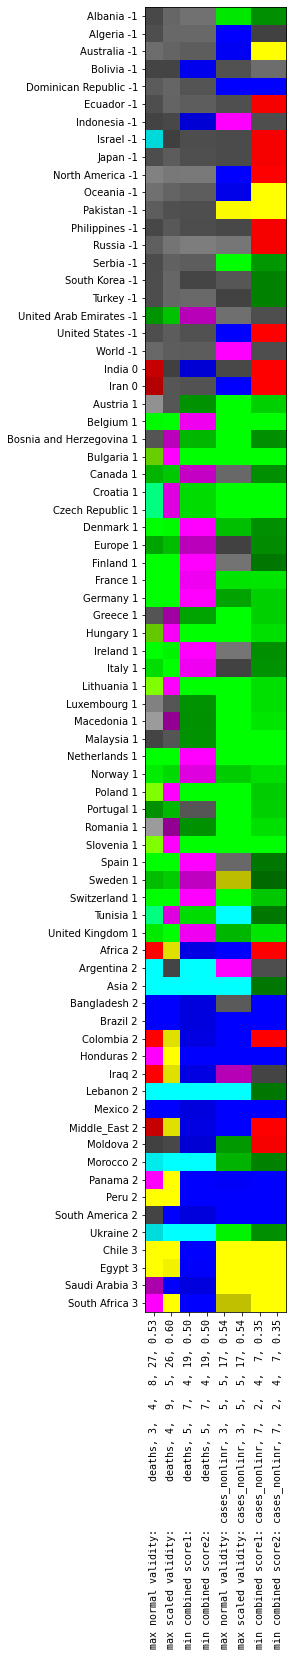

In [12]:
clus.scan() #clus.scan(diag=True) for diagnostic output
clus.make_clusters()
clus.swizzle(satthresh=0.6) # change threshold closer to 1 for more unclustered
clus.plot_swiz()
chosen_swdic = clus.swdic

In [13]:
satthresh_set = 0.6
def cluster_trace(cons, dataname='deaths', country='Australia', satthresh = 0.6):
    global satthresh_set,chosen_swdic,chosen_country
    if satthresh != satthresh_set:
        clus.swizzle(satthresh=satthresh) # change threshold closer to 1 for more unclustered
        chosen_swdic = clus.swdic
        satthresh_set = satthresh
        classes = sprintdic(chosen_swdic,chosen_country)
        class_display.value = classes
    try:
        if country in cons.countries:
            clus.plot_quantile(dataname,'own',country,title=False)
    except:
        clus.plot_quantile(dataname,'own','Australia',title=False)
        
display_countries = clus.countries        
country_display = interactive(cluster_trace,cons=fixed(clus),dataname=clus.cases,country=clus.countries,
                              satthresh= FloatSlider(value = 0.6,min=0.,max=1.0,step=0.01,description='cluster thresh',continuous_update=False));

In [14]:
classes = sprintdic(clus.swdic,chosen_country='Australia')
class_display = widgets.Textarea(value=classes,layout = widgets.Layout(height='320px'))

In [15]:
#display(country_display)
clus.make_map();

In [16]:
clus.map
clus.map.min_height=600;



.
..
0000**Alternate country_fit_trace by analogy to country_display_trace.**

Notes:
* `fit_trace()` creates the model, performs the fit, and produces the solveplot plots.
* `fit_output_text` is a global variable, set by scooping up all of stdout during fit report.

In [17]:
def data_choice(ts,strlist):
    #print(strlist)
    d = list(ts.keys())
    #print(d)
    notstrlist =['new','corrected','smoothed']
    igstrlist =['cumulative','raw','rough']
    for ns in notstrlist:
        if not any(ns in s for s in strlist):
            d = [x for x in d if not ns in x]
    #print(d)
    for s in strlist:
        if not s in igstrlist:
            if not (any('deaths' in s for s in strlist) and ('lin' in s)):
                d = [x for x in d if s in x]
                #print(s,d)
    return d

In [18]:
datasrcs_widget = RadioButtons(options=['jhu','owid'],description='data src',disabled=False,layout={'width': 'max-content'}) 
data_1_widget = RadioButtons(options=['deaths','confirmed'],description='data type',disabled=False,layout={'width': 'max-content'}) 
data_2_widget = RadioButtons(options=['new','cumulative'],description='integration',disabled=False,layout={'width': 'max-content'})
data_3_widget = RadioButtons(options=['corrected','raw'],description='correction',disabled=False,layout={'width': 'max-content'})
data_4_widget = RadioButtons(options=['smoothed','rough'],description='smoothing',disabled=False,layout={'width': 'max-content'})

datanames_widget = Dropdown(options=data_choice(bd.covid_ts,['deaths','new','corrected','smoothed','raw']),
                            description='data chc',disabled=False,layout={'width': 'max-content'}) 

def datachoice_update(*args):
    curr_option = datanames_widget.value
    datanames_widget.options=data_choice(bd.covid_ts,[data_1_widget.value,data_2_widget.value,
                                    data_3_widget.value,data_4_widget.value]) 
    if not curr_option in datanames_widget.options: 
        datanames_widget.value=datanames_widget.options[0]
        
data_1_widget.observe(datachoice_update,'value')
data_2_widget.observe(datachoice_update,'value')
data_3_widget.observe(datachoice_update,'value')
data_4_widget.observe(datachoice_update,'value')

dcbox = VBox([datasrcs_widget,data_1_widget,data_2_widget,data_3_widget,data_4_widget])

In [27]:
countries_common = bd.countries_common  
countries_widget = Dropdown(options=countries_common,description='countries',layout={'width': 'max-content'},value=chosen_country)
modelnames_widget = Dropdown(options=possmodels,description='model',layout={'width': 'max-content'},value='SC3FUEI3R')
modelage_widget = Dropdown(options=[1,4,8,16],description='age grps',layout={'width': 'max-content'},value=1)
fittypes = ['leastsq','nelder','differential_evolution','nelder','slsqp','shgo','cobyla','lbfgsb','bfgs','basinhopping','dual_annealing']
fittypes_widget = Dropdown(options=fittypes,description='fit meth',layout={'width': 'max-content'},value='leastsq')
paramtypes = ['base','ode']
paramtypes_widget = Dropdown(options=paramtypes,description='param base/ode',value='base')
#fit_new_params_widget = ToggleButton(value=True,description='get new params',disabled=False,button_style='',icon='check')
fit_new_params_widget = Checkbox(value=True,description='get new params',disabled=False)
fit_output_text = 'Fit output will be displayed here.'
fit_display_widget = widgets.Textarea(value=fit_output_text,disabled=False,layout = widgets.Layout(height='320px',width='520px'))


def slider_fit_update(*args):
    global MyModel,bd,agemodels,sliderparams,modelnames_widget,modelage_widget,countries_widget,slfit
    modelname = modelnames_widget.value
    agestructure = modelage_widget.value
    country = countries_widget.value
    if int(agestructure) > 1 and modelname in agemodels:
        modelname_a = modelname+'_A'+str(agestructure)
    elif int(agestructure) > 1:  # age structure not yet implemented for this model type
        modelname_a = modelname
        agestructure=1
        modelage_widget.value = agestructure
    else:
        modelname_a = modelname 
    #slfit = SliderFit(modelname=modelname_a,basedata=bd,country=country,run_id="_sltest",data_src='jhu')    
    #return slfit    
        

    
countries_widget.observe(slider_fit_update,'value')
modelnames_widget.observe(slider_fit_update,'value')
modelage_widget.observe(slider_fit_update,'value')

def swizzle_update(*args):
    country_display


#def datanames_update(*args):
#    if datasrcs_widget.value == 'jhu':
#        datanames_widget.options = list(bd.covid_ts.keys())
#    elif datasrcs_widget.value == 'owid':
#        datanames_widget.options = list(bd.covid_owid_ts.keys()) 
#datasrcs_widget.observe(datanames_update,'options')

def countries_update(*args):
    global chosen_country,chosen_class,countries_common
    #if chosen_country in countries_common:
    countries_widget.value = country_display.children[1].value
    # else:
    # countries_widget.value = countries_widget.value
    class_display.value = sprintdic(clus.swdic,chosen_country=countries_widget.value)

country_display.children[1].observe(countries_update,'value')

def common_trace(datasrc = 'jhu', dataname='deaths',country='Australia'):
    global bd,countries_common
    if country in countries_common:
        if datasrc == 'jhu':
            ts = bd.covid_ts
        elif datasrc == 'owid':
            ts = bd.covid_owid_ts
        else:
            print('Error in datasrc')
        if dataname in ts:    
            if 'deaths' in dataname:
                plt.plot(ts[dataname][country],color='red')
            elif 'confirmed' in dataname:
                plt.plot(ts[dataname][country],color='green')
        else:
            print('dataname not found',dataname)
            
country_display_trace = interactive_output(common_trace,{'datasrc':datasrcs_widget,'dataname':datanames_widget,'country':countries_widget});

In [20]:
def allsliderparams(modelname,params_init_min_max={}):
    """
        construct dictionary of slider widgets corresponding to 
        input params_init_min_max is the dictionary of tuples for parameter optimization (3 or 4-tuples)
        pimm is short name for params_init_min_max
    """
    pimm = params_init_min_max
    if pimm == {}:
        print('missing non empty dictionary params_init_min_max')
        return
    elif len(pimm[list(pimm.keys())[0]]) != 4:
        print('dictionary params_init_min_max must contain tuples with 4 entries (val,min,max,step)')
        return
    slidedict = {}
    slider_layout = Layout(width='400px', height='12px')
    style = {'description_width': 'initial'}
    slidedict.update({'param_class':fixed('base')})
    slidedict.update({'figsize':fixed((8,5))})
    for pm in pimm:
        if pm != 'param_class':
            if ((not 'Caution' in pm) or 'C' in modelname) and ((not 'Econom' in pm) or 'U' in modelname) and ((not 'Young' in pm) or '_A' in modelname) and ((not 'Fatigue' in pm) or 'F' in modelname):
                slidedict.update({pm:FloatSlider(min=pimm[pm][1],max=pimm[pm][2],step=pimm[pm][3],value=pimm[pm][0],description=pm,
                            style=style,
                            layout=slider_layout,
                            continuous_update=False,readout_format='.3f')})
    return slidedict 

In [21]:
modelname = 'SC3FUEI3R'
MyModel =  ModelFit(modelname,basedata=bd,country='Australia',run_id="_test1",data_src='jhu')
def fit_trace(modelname='SC3FUEI3R',agestructure=1,fittype='leastsq',datasrc='jhu',country='Australia',paramtype = 'base',fit_new_params = True):
    global bd,MyModel,params_init_min_max,params_init_min_max_slider,fit_new_params_widget
    global sliders_widgets,sliderparams,sliders,bsliders,slbox,f2s_button,s2f_button
    if int(agestructure) > 1 and modelname in agemodels :
        modelname_a = modelname+'_A'+str(agestructure)
    elif int(agestructure) > 1:  # age structure not yet implemented for this model type
        modelname_a = modelname
        agestructure=1
        modelage_widget.value = agestructure
    else:
        modelname_a = modelname
    try:
        old_stdout = sys.stdout
        sys.stdout = mystdout = io.StringIO()
        ###############################################
        ## do the fit
        #MyModel = ModelFit('SC3EI3R',basedata=bd,data=ClData.clusdata_all,country=country,run_id="_test1",data_src='cluster')
        if MyModel == None or MyModel.modelname!=modelname:
            MyModel = ModelFit(modelname_a,basedata=bd,country=country,run_id="_test1",data_src=datasrc)
                # params_init_min_max = sim_param_inits[modelname]       # sim_param_inits defined in model_fits_age.py
            params_init_min_max = default_fit_params()
            params_init_min_max_slider = params_init_min_max.copy()
            # params_init_min_max_slider = MyModel.transfer_fit_to_params_init(params_init_min_max_slider)
            sliderparams = allsliderparams(modelname,params_init_min_max_slider)
            if sliderparams:
                sliders_widgets=interactive_output(MyModel.slidefitplot,sliderparams)
                sliders=VBox([w1 for w1 in list(sliderparams.values()) if isinstance(w1,Widget)])
                bsliders=VBox([f2s_button,s2f_button,sliders])
                slbox=HBox([sliders_widgets,bsliders])     
        elif MyModel.country != country or MyModel.data_src != datasrc:
            MyModel.data_src = datasrc
            MyModel.setup_data(country)
        if fit_new_params_widget.value:
            if paramtype == 'ode':
                if fit_new_params:
                    params_init_min_max = sim_param_inits[modelname]       # sim_param_inits defined in model_fits_age.py
                MyModel.model.parameters = {p:params_init_min_max[p][0] for p in params_init_min_max if p != 'logI_0'}
                MyModel.params.update({p:params_init_min_max[p][0] for p in params_init_min_max if p != 'logI_0'})
            elif paramtype == 'base':
                if fit_new_params:
                    params_init_min_max = default_fit_params()
                params_in = base2params(MyModel.sbparams,MyModel.cbparams,MyModel.fbparams,modelname_a)
                # need to check transfer of parameteres and compatibility
            if 'logI_0' in params_init_min_max:
                MyModel.set_I0(params_init_min_max['logI_0'][0])
        fit_display_widget.value = "Processing fit, please wait ..."
        
        fit_ctrl = {'max_nfev':None,'ftol':0.001,'xtol':0.01,'epsfcn':0.0001} # one can try setting these to improve fit behaviour
        #fit_ctrl = {}
        # MyModel.fit(params_init_min_max,fit_targets=['deaths'],fit_data=['deaths_corrected_smoothed'],diag=True,report=True,conf_interval=False,fit_kws=fit_ctrl)
        # MyModel.fit(params_init_min_max,fit_targets=['confirmed'],fit_data=['confirmed_corrected_smoothed'],diag=True,report=True,conf_interval=False,fit_kws=fit_ctrl)
        #MyModel.fit(params_init_min_max,fit_method='differential_evolution',fit_targets=['deaths'],fit_data=['deaths_corrected_smoothed'],diag=True,report=True,conf_interval=False,fit_kws=fit_ctrl)

        if fittype=='leastsq':
            MyModel.fit(params_init_min_max,param_class=paramtype,fit_method='leastsq',fit_targets=['deaths','confirmed'],fit_data='default',diag=False,report=True,conf_interval=False,fit_kws=fit_ctrl)
        else:
            MyModel.fit(params_init_min_max,param_class=paramtype,fit_method=fittype,fit_targets=['deaths','confirmed'],fit_data='default',diag=False,report=True,conf_interval=False)
        #MyModel.fit(params_init_min_max,fit_method='nelder',fit_targets=['deaths'],fit_data='default',diag=True,report=True,conf_interval=False)
        # MyModel.fit(params_init_min_max,fit_targets=['deaths','confirmed'],fit_data=['deaths_corrected_smoothed','confirmed_corrected_smoothed'])
        ax=MyModel.solveplot(['deaths','confirmed','caution_fraction','economy'],
                      datasets=['deaths_corrected_smoothed','confirmed_corrected_smoothed'],
                      mag={'deaths':30.},newplot=True,figsize=(8,5));
        fit_display_widget.value = mystdout.getvalue()   #  fit_output_widget global.
    finally:
        sys.stdout = old_stdout

#country_fit_trace = interactive_output(fit_trace,{'modelname':modelnames_widget,'fittype':fittypes_widget,'datasrc':datasrcs_widget,'dataname':datanames_widget,'country':countries_widget});
country_fit_trace = interactive_output(fit_trace,{'modelname':modelnames_widget,'agestructure':modelage_widget,'fittype':fittypes_widget,
                                                  'datasrc':datasrcs_widget,'country':countries_widget,'paramtype':paramtypes_widget,'fit_new_params':fit_new_params_widget});

In [22]:
def getsliderparams(sliderparams):
    """
        use dictionary of slider widgets to get params_init_min_max 
        which is the dictionary of tuples for parameter optimization (4-tuples)
    """
    params_init_min_max = {}
    for pm in sliderparams.keys():
        #print('pm',pm,'value',sliderparams[pm].value)
        if pm != 'param_class' and pm != 'figsize':
            params_init_min_max.update({pm:(sliderparams[pm].value,sliderparams[pm].min,sliderparams[pm].max,sliderparams[pm].step)})
    return params_init_min_max

In [23]:
def setsliderparams(params_init_min_max={},sliderparams={}):
    """
        set values and limits in dictionary of slider widgets from params_init_min_max 
    """
    pimm = params_init_min_max
    if pimm == {} or sliderparams == {}:
        print('missing dictionary params_init_min_max or sliderparams')
        return
    elif len(pimm[list(pimm.keys())[0]]) != 4:
        print('dictionary params_init_min_max must contain tuples with 4 entries (val,min,max,step)')
        return
    for pm in pimm:
        #print('pm',pm,'value',sliderparams[pm].value)
        if pm != 'param_class' and pm != 'figsize' and pm in sliderparams:
            sliderparams[pm].value= pimm[pm][0]
            sliderparams[pm].min= pimm[pm][1]
            sliderparams[pm].max= pimm[pm][2]
            sliderparams[pm].step= pimm[pm][3]
    return

In [24]:
s2f_button = widgets.Button(description="Transfer to fit ICs")
def s2f_on_button_clicked(b):
    global params_init_min_max, sliderparams
    params_init_min_max = getsliderparams(sliderparams)

s2f_button.on_click(s2f_on_button_clicked)

In [25]:
f2s_button = widgets.Button(description="Transfer ICs from fit")
def f2s_on_button_clicked(b):
    global params_init_min_max, sliderparams
    setsliderparams(params_init_min_max,sliderparams)

f2s_button.on_click(f2s_on_button_clicked)

In [29]:
# params_init_min_max = sim_param_inits[modelname]       # sim_param_inits defined in model_fits_age.py
params_init_min_max = default_fit_params()
params_init_min_max_slider = params_init_min_max.copy()
# params_init_min_max_slider = MyModel.transfer_fit_to_params_init(params_init_min_max_slider)
sliderparams = allsliderparams(modelname,params_init_min_max_slider)
if sliderparams:
    sliders_widgets=interactive_output(MyModel.slidefitplot,sliderparams)
    sliders=VBox([w1 for w1 in list(sliderparams.values()) if isinstance(w1,Widget)])
    bsliders=VBox([f2s_button,s2f_button,sliders])
    slbox=HBox([sliders_widgets,bsliders])

In [30]:
cbox = VBox([datanames_widget,countries_widget,country_display_trace])  
choicebox = HBox([modelnames_widget, modelage_widget, fittypes_widget])
modbox=HBox([paramtypes_widget, fit_new_params_widget])
sbox = VBox([choicebox,modbox,country_fit_trace])
myhbox1 = HBox([country_display,class_display,dcbox,cbox])
myhbox2 = HBox([sbox,VBox([Label('Fit output data'),fit_display_widget]),slbox])
#myhbox2 = HBox([sbox])
#myhbox2 = [country_fit_trace]
#VBox([mybox,clus.map]) 
VBox([myhbox1,myhbox2,clus.map])
#VBox([myhbox1,myhbox2])

In [45]:
modelname = 'SC3FUEI3R'
MyModel = ModelFit(modelname,basedata=bd,country='Australia',run_id="_test1",data_src='jhu')
params_init_min_max = sim_param_inits[modelname]       # sim_param_inits defined in model_fits_age.py
params_init_min_max = default_fit_params()
params_init_min_max_slider = params_init_min_max.copy()
params_init_min_max_slider = MyModel.transfer_fit_to_params_init(params_init_min_max_slider)


#sliderparams = MyModel.allsliderparams(params_init_min_max_slider)
sliderparams = allsliderparams(modelname,params_init_min_max_slider)
sliderparams.update({'param_class':fixed('ode')})

In [34]:
setsliderparams(params_init_min_max,sliderparams)

In [35]:
if MyModel.model._explicitOde is False: # only for all models without U in name and for all age models, defined by transitions not explicit ODE
    MyModel.model.get_transition_graph() 

In [32]:
MyModel.params

{'beta_1': 0.4,
 'beta_2': 0.0,
 'beta_3': 0.0,
 'alpha': 0.2,
 'gamma_1': 0.06999999999999999,
 'gamma_2': 0.16666666666666669,
 'gamma_3': 0.1,
 'p_1': 0.030000000000000013,
 'p_2': 0.08333333333333333,
 'mu': 0.1,
 'c_0': 0.1,
 'c_1': 0.016666666666666666,
 'c_2': 10.0,
 'c_4': 0.016666666666666666,
 'k_u': 0.03333333333333333,
 'k_1': 0.016666666666666666,
 'k_w': 0.016666666666666666,
 'kappa': 0.5,
 'N': 1}

In [65]:
# params_init_min_max = sim_param_inits[modelname]       # sim_param_inits defined in model_fits_age.py
params_init_min_max = default_fit_params()
params_init_min_max_slider = params_init_min_max.copy()
# params_init_min_max_slider = MyModel.transfer_fit_to_params_init(params_init_min_max_slider)
sliderparams = allsliderparams(modelname,params_init_min_max_slider)
if sliderparams:
    sliders_widgets=interactive_output(MyModel.slidefitplot,sliderparams)
    sliders=VBox([w1 for w1 in list(sliderparams.values()) if isinstance(w1,Widget)])
    bsliders=VBox([f2s_button,s2f_button,sliders])
    slbox=HBox([sliders_widgets,bsliders])

# SliderFit for Dashboard

In [73]:
exec(open('ModelFit.py','r').read())

In [87]:
s2f_button = widgets.Button(description="Transfer to fit ICs")
def s2f_on_button_clicked(b):
    global params_init_min_max, sliderparams
    params_init_min_max = getsliderparams(sliderparams)

s2f_button.on_click(s2f_on_button_clicked)

In [88]:
f2s_button = widgets.Button(description="Transfer ICs from fit")
def f2s_on_button_clicked(b):
    global params_init_min_max, sliderparams
    setsliderparams(params_init_min_max,sliderparams)

f2s_button.on_click(f2s_on_button_clicked)

In [89]:
modelname = 'SC3FEI3R'
country = 'United States'
slfit = None
#slfit = SliderFit(modelname=modelname,basedata=bd,country=country,run_id="_sltest",data_src='jhu')
#slfit.slbox
from ipywidgets.widgets import Text
runid_widget = Text(value=None,placeholder='Enter run id',description='Run_id:',disabled=False)
#,'paramtype':paramtypes_widget,'fit_new_params':fit_new_params_widget
#'agestructure':modelage_widget,'fittype':fittypes_widget,
def slider_fit(modelname=modelname,basedata=bd,country=country,run_id="_sltest",data_src='jhu'):
    global slfit
    slfit = SliderFit(modelname=modelname,basedata=basedata,country=country,run_id=run_id,data_src=data_src)
    display(slfit.slbox)
    
slfit_widget = interactive_output(slider_fit,{'modelname':modelnames_widget,'basedata':fixed(bd),'country':countries_widget,'run_id':runid_widget,
                                                  'data_src':datasrcs_widget});
slall=VBox([modelnames_widget,countries_widget,datasrcs_widget,runid_widget,f2s_button,s2f_button,slfit_widget]);
display(slall)

# SliderFit

In [42]:
exec(open('ModelFit.py','r').read())

In [43]:
modelname = 'SC3FEI3R'
country = 'United States'
slfit = SliderFit(modelname=modelname,basedata=bd,country=country,run_id="_sltest",data_src='jhu')
slfit.slbox


In [37]:
[x for x in slfit.slidedict]



['param_class',
 'figsize',
 'beta_1',
 'alpha',
 'mu',
 'c_0',
 'c_1',
 'c_2',
 'c_4',
 'logI_0']

In [32]:
slfit.slbox

In [37]:
slfit.transfer_cur_to_params_init()

In [24]:
slfit.params_init_min_max

{'beta_1': (0.558, 0.0, 1.2, 0.001),
 'alpha': (0.2, 0.0, 1.0, 0.001),
 'mu': (0.1, 0.0, 0.5, 0.001),
 'c_0': (0.1, 0.0, 1.0, 0.001),
 'c_1': (0.016, 0.0, 0.1, 0.001),
 'c_2': (5.55, 1.0, 200.0, 0.01),
 'c_4': (0.007, 0.0, 0.1, 0.001),
 'logI_0': (-8.691, -12.0, -3.0, 0.001)}

In [25]:
slfit.fit()

elapsed time =  4.934804439544678
Param c_2 within 2.34 % of min.
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 184
    # data points      = 307
    # variables        = 8
    chi-square         = 0.37084638
    reduced chi-square = 0.00124029
    Akaike info crit   = -2046.67624
    Bayesian info crit = -2016.86146
[[Variables]]
    beta_1:  0.63453780 +/- 1.01432327 (159.85%) (init = 0.558)
    alpha:   0.31809628 +/- 1.14385439 (359.59%) (init = 0.2)
    mu:      0.05217084 +/- 0.19157717 (367.21%) (init = 0.1)
    c_0:     0.20362260 +/- 0.29702897 (145.87%) (init = 0.1)
    c_1:     0.01651694 +/- 0.01140906 (69.07%) (init = 0.016)
    c_2:     5.66219545 +/- 24.0086027 (424.02%) (init = 5.55)
    c_4:     0.02925412 +/- 0.01444742 (49.39%) (init = 0.007)
    logI_0: -9.71460149 +/- 1.09293698 (11.25%) (init = -8.691)
[[Correlations]] (unreported correlations are < 0.100)
    C(beta_1, alpha)  = -1.000
    C(mu, c_2)        =  0.998
    C(mu, logI_0)

<AxesSubplot:>

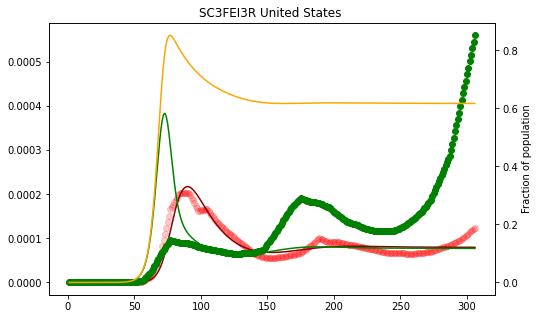

In [27]:
slfit.solveplot(['deaths','confirmed','caution_fraction','economy'],
                      datasets=['deaths_corrected_smoothed','confirmed_corrected_smoothed'],
                      mag={'deaths':30.},newplot=True,figsize=(8,5))

In [28]:
slfit.params

{'beta_1': 0.6345378034554706,
 'beta_2': 0.0,
 'beta_3': 0.0,
 'alpha': 0.3180962781230594,
 'gamma_1': 0.06999999999999999,
 'gamma_2': 0.16666666666666669,
 'gamma_3': 0.1,
 'p_1': 0.030000000000000013,
 'p_2': 0.08333333333333333,
 'mu': 0.05217083622691468,
 'c_0': 0.20362260061551557,
 'c_1': 0.01651694405583462,
 'c_2': 5.6621954543746735,
 'c_4': 0.029254116252873365,
 'N': 1}